## Instroduction

This document contains a case study introduced by the Google Analytics team from the data analysis certificated from Coursera.
https://www.coursera.org/professional-certificates/google-data-analytics

Part of the cleaning and analysis made to the data come from the guide line document provided in the course.

The student was required to explore and modify the analysis, make conclusions and make a report with 3 principal recommendations to solve the company's main problem. All data used for this case comes from the Divvybikes.com a bike-share company from chicago: https://ride.divvybikes.com/

## The Case Study

Cyclistic (a bike-share company) wants to increment their user population on the yearly subscrupcion they offer to customers. The company has two types of users: casual users, which use bikes for just one day, and members who are subscribed to their yearly program.

The company wants to attract more casual users to the yearly program since it's the one that generates more revenue. 

To do a business plan to attract more members, the company provided their data-set with information about trips information all users. The users are clyssfied in two `casual` and `member` into the dataset. I took data from 2019 last quarters and 2020 first quarter to identify patterns that helpe to form a business plan/strategy.

#### key stakeholders

* 1. Cyclistic executive team

* 2. Lily Moreno, Director of marketing.

### 1. Ask

Business task:

Why would casual riders buy Cyclistic annual memberships?

How can Cyclistic use digital media to influence casual riders to become members?

## Devepment
### 2. Prepare

Downloaded the files from divvy's dataset: https://divvy-tripdata.s3.amazonaws.com/index.html

I stored the dataset in a local folder separating the CSV original files and the copy I am working on.

`~/CSV
 ~/CSV-Copy/Working-directory
 `

Once the dataset is organized with a back-up, I use RStudio for the analysis. The google data analysis course provided a scrip to use in R for cleaning and processsing. The Examples used the data from divvy's dataset. Data is organized from quarters and is taken from the last 3 quarters of 2019 and the first quarter of 2020 to represent a whole year of user activity.

Script guideline and requirements on the link below:

https://docs.google.com/document/d/1TTj5KNKf4BWvEORGm10oNbpwTRk1hamsWJGj6qRWpuI/edit

dataset used on R script:

`q2_2019 <- read_csv("Divvy_Trips_2019_Q2.csv"),
q3_2019 <- read_csv("Divvy_Trips_2019_Q3.csv"),
q4_2019 <- read_csv("Divvy_Trips_2019_Q4.csv"),
q1_2020 <- read_csv("Divvy_Trips_2019_Q1.csv")`

Merge

`all_trips <- bind_rows(q2_2019, q3_2019, q4_2019, q1_2020)`

### 3. Process

After merging all datasets under the variable `all_trips` we removed the columns that were dropped on tables from 2020 and after.

`all_trips <- all_trips %>%  
  select(-c(start_lat, start_lng, end_lat, end_lng, birthyear, gender))`
`

In [1]:
library(tidyverse)  #helps wrangle data
#library(lubridate)  #helps wrangle date attributes (used on the R script to edit and arrange date related information)
library(ggplot2)  #helps visualize data

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
#Loading dataset
all_trips <- read_csv("../input/cyclisticdataset/all_trips.csv")

table(all_trips$member_casual)

New names:
* `` -> ...1

Rows: 3879822 Columns: 20

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (7): ride_id, rideable_type, start_station_name, end_station_name, mem...
dbl  (11): ...1, 01 - Rental Details Duration In Seconds Uncapped, start_sta...
dttm  (2): started_at, ended_at


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.




    casual   Customer     member Subscriber 
     48480     857474     378407    2595461 

In [3]:
# Reassign to the desired values (we will go with the current 2020 labels)
all_trips <-  all_trips %>% 
  mutate(member_casual = recode(member_casual
                                ,"Subscriber" = "member"
                                ,"Customer" = "casual"))

In [4]:
#check
table(all_trips$member_casual)


 casual  member 
 905954 2973868 

In [5]:
#Then the dataset is further clean to extract more information from the dataset like trip duration date when the trip was made and the type of user that did it.
all_trips$date <- as.Date(all_trips$started_at) #The default format is yyyy-mm-dd
all_trips$month <- format(as.Date(all_trips$date), "%m")
all_trips$day <- format(as.Date(all_trips$date), "%d")
all_trips$year <- format(as.Date(all_trips$date), "%Y")

#Agregating a column with days of the week:
all_trips$day_of_week <- format(as.Date(all_trips$date), "%A")

# Add a "ride_length" calculation to all_trips (in seconds)
all_trips$ride_length <- difftime(all_trips$ended_at,all_trips$started_at)

# Convert "ride_length" from Factor to numeric so we can run calculations on the data
all_trips$ride_length <- as.numeric(as.character(all_trips$ride_length))
is.numeric(all_trips$ride_length)

[1] TRUE

##### Removing "bad" data
The data frame includes a few hundred entries when bikes were taken out of docks and checked for quality by Divvy. Also, there are negative values in ride_length column. We will address the changes in a new version V2.

In [6]:
all_trips_v2 <- all_trips[!(all_trips$start_station_name == "HQ QR" | all_trips$ride_length<0),]

#Organizing days of the week.
all_trips_v2$day_of_week <- ordered(all_trips_v2$day_of_week, levels=c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"))

### 4. Analysis
After preparing and cleaning the main data-set it to identify patterns. In order to avoid uploading the whole data set, we will separate the data into smaller data sets. Each data set represents some of the questions Cyclistics has about their users. Like weekly and monthly ride count as well as ride duration.

To understand how different types of users differentiate from each other, we need to classify their trips by trip duration and trip count.

Average ride time by each day for embers VS casual users, the data is separated, in days of the week and there is, also a monthly version.

In [7]:
#Ride frequency by member type, for each day of the week.
mean_duration_week <- aggregate(all_trips_v2$ride_length ~ all_trips_v2$member_casual + all_trips_v2$day_of_week, FUN = mean)
mean_duration_month <- aggregate(all_trips_v2$ride_length ~ all_trips_v2$member_casual + all_trips_v2$month, FUN = mean)


count_day_week <- as.data.frame(table(all_trips_v2$member_casual, all_trips_v2$day_of_week))
count_month <- as.data.frame(table(all_trips_v2$member_casual, all_trips_v2$month))

### Creating Specific Tables

In [8]:
#Analysis based on weekly comparison and information
mean_duration_week <- aggregate(all_trips_v2$ride_length ~ all_trips_v2$member_casual + all_trips_v2$day_of_week, FUN = mean)
count_day_week <- as.data.frame(table(all_trips_v2$member_casual, all_trips_v2$day_of_week))

#Analysis based on weekly comparison and information
mean_duration_month <- aggregate(all_trips_v2$ride_length ~ all_trips_v2$member_casual + all_trips_v2$month, FUN = mean)
count_month <- as.data.frame(table(all_trips_v2$member_casual, all_trips_v2$month))

In [9]:
head(mean_duration_week)
head(count_day_week)
head(mean_duration_month)
head(count_month)


,all_trips_v2$member_casual,all_trips_v2$day_of_week,all_trips_v2$ride_length
,<chr>,<ord>,<dbl>
1,casual,Sunday,3581.4054
2,member,Sunday,919.9746
3,casual,Monday,3372.2869
4,member,Monday,842.5726
5,casual,Tuesday,3596.3599
6,member,Tuesday,826.1427


,Var1,Var2,Freq
,<fct>,<fct>,<int>
1,casual,Sunday,181293
2,member,Sunday,267965
3,casual,Monday,103296
4,member,Monday,472196
5,casual,Tuesday,90510
6,member,Tuesday,508445


,all_trips_v2$member_casual,all_trips_v2$month,all_trips_v2$ride_length
,<chr>,<chr>,<dbl>
1,casual,01,9698.9692
2,member,01,668.9423
3,casual,02,7997.1646
4,member,02,768.3972
5,casual,03,4250.2230
6,member,03,860.0644


,Var1,Var2,Freq
,<fct>,<fct>,<int>
1,casual,01,7785
2,member,01,136099
3,casual,02,12314
4,member,02,126714
5,casual,03,24615
6,member,03,115593


### Cleaning new tables
#### Renaming cells

In [10]:
mean_duration_week <- rename(mean_duration_week,
                        day_of_week = `all_trips_v2$day_of_week`,
                        ride_length = `all_trips_v2$ride_length`,
                        member_casual = `all_trips_v2$member_casual`)

count_day_week <- rename(count_day_week, 
                         member_casual = Var1, day_of_week = Var2,
                         count = Freq)

mean_duration_month <- rename(mean_duration_month,
                        month = `all_trips_v2$month`,
                        ride_length = `all_trips_v2$ride_length`,
                        member_casual = `all_trips_v2$member_casual`)

count_month <- rename(count_month, 
                         member_casual = Var1, month = Var2,
                         count = Freq)

## Results
### 5. Share
**Weekly arrenge charts**

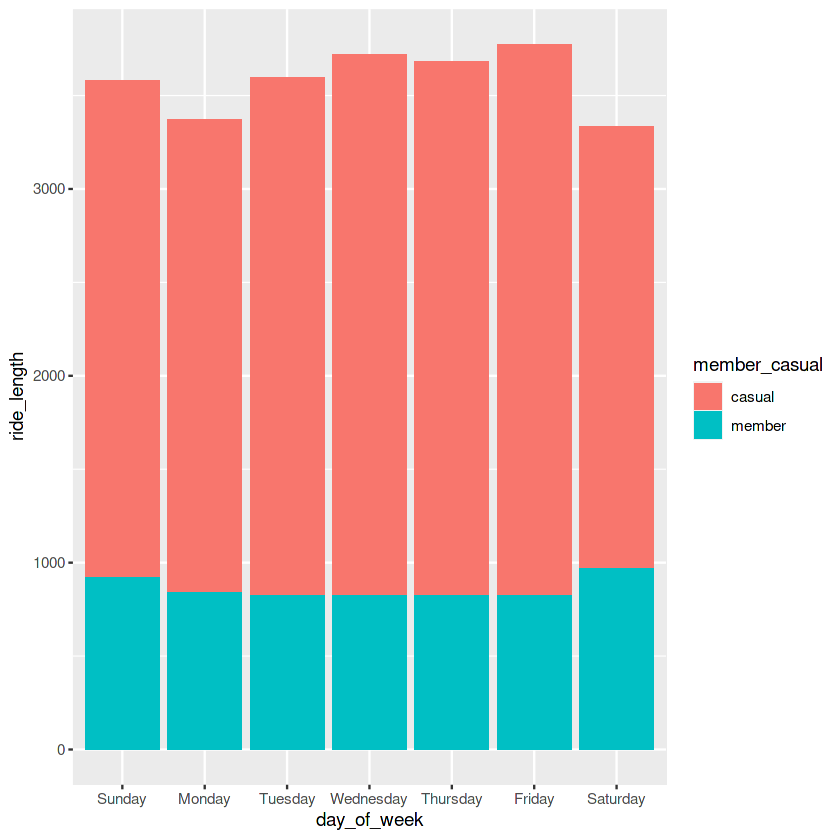

In [11]:
#Creating a visualization for average duration, for every day of the week
mean_duration_week %>%
  ggplot(aes(x = day_of_week, y = ride_length
             , fill = member_casual)) +
  geom_col(position = "identity")

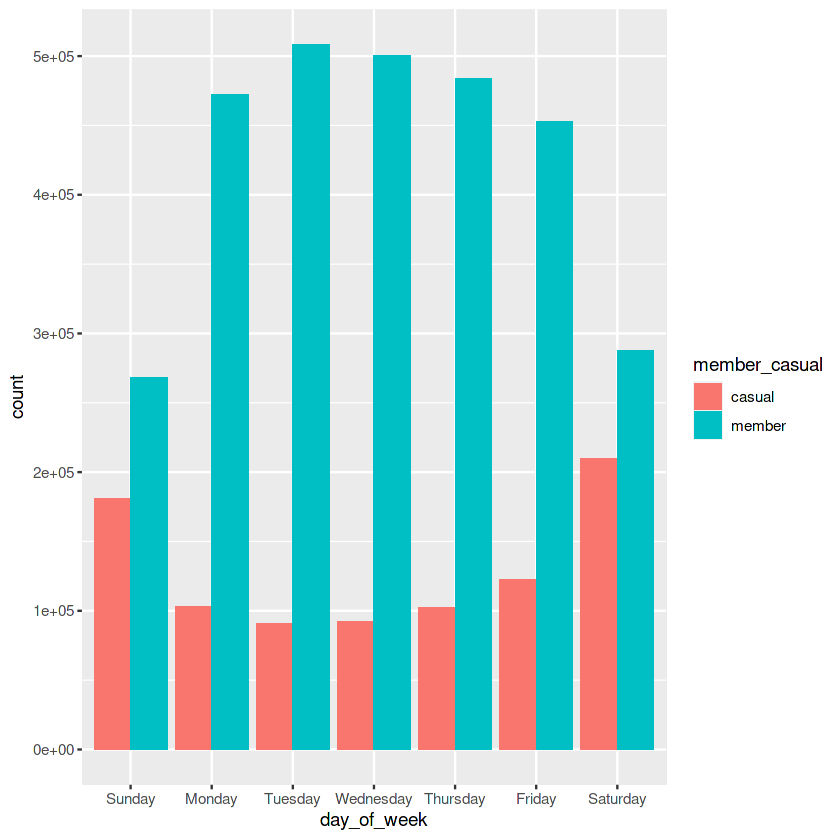

In [12]:
#Visualizing the number of rides by rider type, for every day of the week
count_day_week %>%
  ggplot(aes(x = day_of_week, y = count
             , fill = member_casual)) +
  geom_col(position = "dodge")

In [13]:
## month to numeric
mean_duration_month$month <- as.numeric(as.character(mean_duration_month$month))
count_month$month <- as.numeric(as.character(count_month$month))
is.numeric(mean_duration_month$month)
is.numeric(count_month$month)

[1] TRUE

[1] TRUE

**Monthly Arrange Charts**

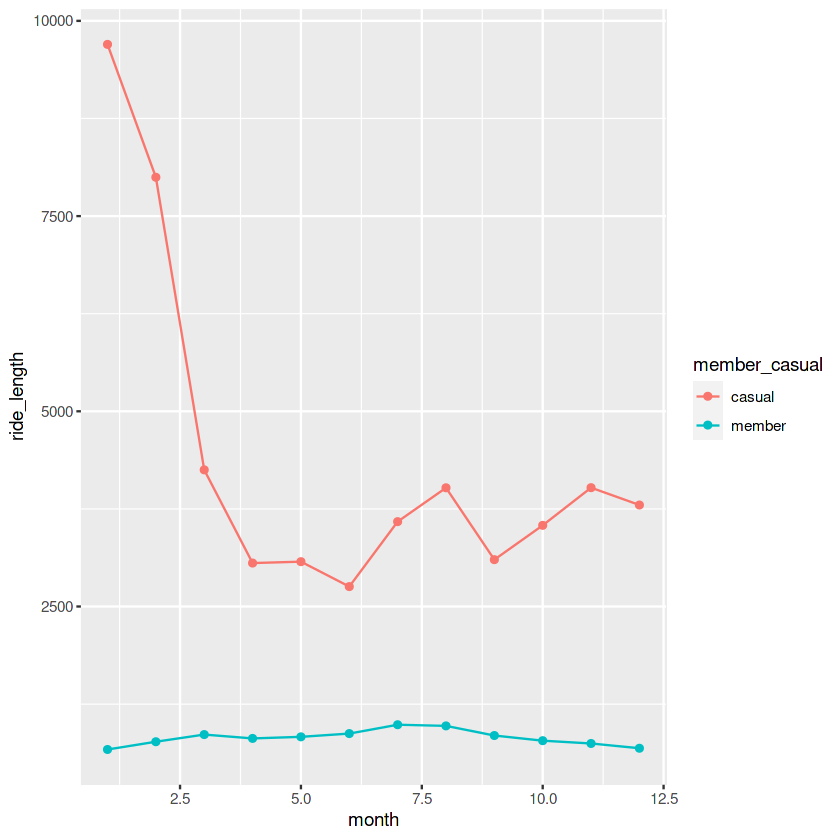

In [14]:
#Creating a visualization for average duration for every month of the year 2019-2020
mean_duration_month %>%
  ggplot(aes(x = month, y = ride_length
             , color = member_casual)) +
  geom_point() +
  geom_line()

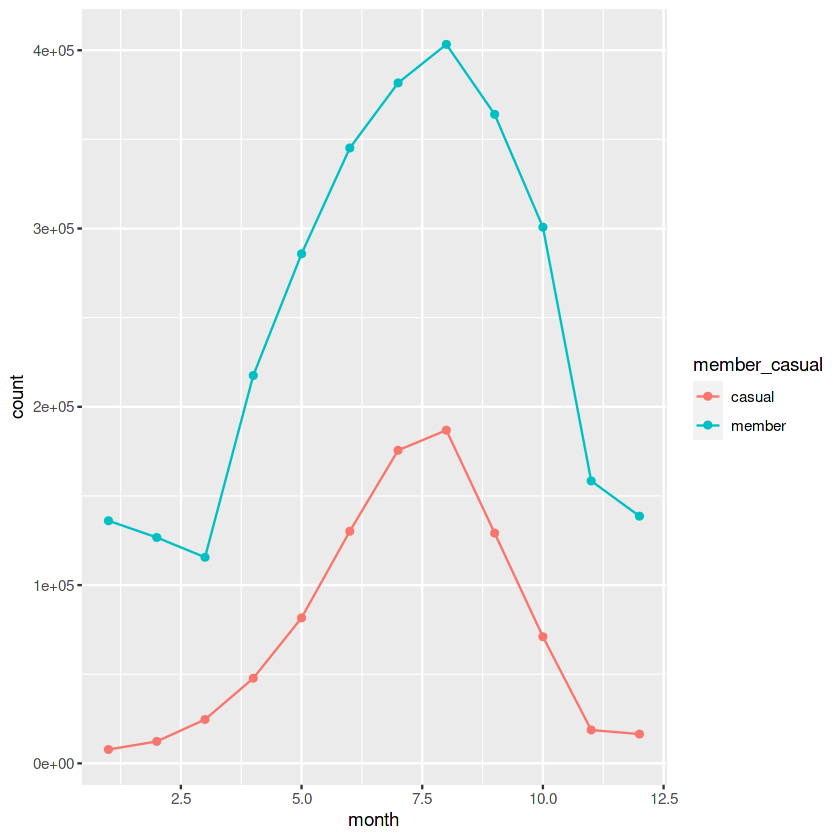

In [15]:
#Visualizing the number of rides by rider type for every month of the year 2019-2020

count_month %>%
  ggplot(aes(x = month, y = count
             , color = member_casual)) +
  geom_point() +
  geom_line()

## Conclusion

After analysing the data-sets, these are the patterns and conclusions I found.

1. Members take more rides on working days.
2. Casual users take more rides on weekends.
3. Casual users take longer rides on average compared to members.
4. Winter is the less demanded season for both users.
5. longer rides from casual users come between February and January.

### 6. Act

Propositions for stakeholders:
* Since casual users spend most of their rides on weekends, Cyclistic can create a different membership based on weekends.
* Cyclistic can promote a temporary program for casual users that reward them based on the distance they travel. This proposal is based on data that indicates casual riders take longer rides. Rewards can include:
  *An extra pass for the weekends to give to a partner for rides.
  *Discounts in participant stores.
* The company can also go further in the analysis and make surveys to understand their users better. These surveys can contain information about the region. This can help the company make dedicated rewards and promotion programs. the objective of the new survey could be to know about users going for different memberships. (monthly instead of yearly).